## QVMC Intro
Using the Illinois tutorial - https://clark.physics.illinois.edu/Tutorials/VMCIntroTutorial/index.html
Hydrogen molecule - one spin up, one spin down.

In [7]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from stats import Stats

In [8]:
def modulo(x):
    return sum([i**2 for i in x])

def euclidean_distance(r1, r2):

    dist = 0
    for i in range(len(r1)):
        dist += (r1[i] - r2[i]) ** 2
    
    return np.sqrt(dist) 

### Trial Wavefunction 1 - Gaussian with a variational width

In [9]:
def psi(coords, ions=None, alpha=0.5):
    return np.exp(- alpha * (modulo(coords[0]) + modulo(coords[1])))


In [10]:
psi_(np.array([[1.0 ,0.5 ,0.3], [-0.2, 0.1, -0.1]]))

NameError: name 'psi_' is not defined

In [11]:
coords = [[1.0 ,0.5 ,0.3], [-0.2, 0.1, -0.1]]
psi(coords)

np.float64(0.49658530379140947)

### Accepting and rejecting moves

In [12]:
def VMC(WF, ions, numSteps):

    ratios = []
    coords_arr = []

    R = np.zeros((2, 2), float)
    movesAttempted = 0.0
    movesAccepted = 0.0
    coords = np.zeros((2, 3))
    original_WF = WF(coords, ions)
    for step in range(numSteps):
        for ptcl in range(len(R)):
            a = 5  # Define movement parameters
            # Implement move for particle 'ptcl'
            delta = 1
            move_coords = delta * 1.5 * np.random.rand(3)
            move_coords[2] = 0
            new_coords = coords.copy()

            if random.random() <= 0.5:
                new_coords[ptcl] += move_coords
            else:
                new_coords[ptcl] -= move_coords
            
            new_WF = WF(new_coords, ions)

            if new_WF:
                
                ratio = (new_WF / original_WF) ** 2

                if random.random() <= ratio:
                    movesAccepted += 1
                    coords_arr.append(new_coords[ptcl])
                    #coords = new_coords.copy()
                    #original_WF = new_WF
                
                ratio = min(1, ratio)
                ratios.append(ratio)

            movesAttempted += 1
            
    print("Acceptance ratio:", movesAccepted / movesAttempted)
    return coords_arr

In [13]:
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])
coords_arr = VMC(psi, ions=ions, numSteps=10000)

Acceptance ratio: 0.3211


In [14]:
coords_x = [i[0] for i in coords_arr]

In [15]:
t = [4, 3, 0]

np.linalg.norm(t)

np.float64(5.0)

### Local energy

In [60]:
def LaplacianPsiOverPsi(wavefunction, R, alpha, ions=None, delta=1e-3):
    r_plus = np.copy(R)
    r_minus = np.copy(R)
    wavefunction_current = wavefunction(R)

    kinetic_energy = 0.0
    for i in range(2):
        for j in range(3):
            r_plus[i, j] += delta
            r_minus[i, j] -= delta

            wave_function_plus = wavefunction(r_plus)
            wave_function_minus = wavefunction(r_minus)

            kinetic_energy -= (
                wave_function_minus + wave_function_plus - 2 * wavefunction_current)

            r_plus[i, j] = R[i, j]
            r_minus[i, j] = R[i, j]

    # Kinetic energy
    kinetic_energy = kinetic_energy *  0.5 * 1e6 / wavefunction_current

    return kinetic_energy

def analytical_KE(wavefunction, coords, alpha):

    k1 = 4 * alpha ** 2 * (np.linalg.norm(coords[0]) ** 2 + np.linalg.norm(coords[1]) ** 2 )
    k2 = 12 * alpha
    return - (k1 - k2) * 0.5

def LocalEnergy(wavefunction, coords, ions, alpha, display=False):

    #kinetic_energy = LaplacianPsiOverPsi(wavefunction, coords, alpha)
    kinetic_energy = analytical_KE(wavefunction, coords, alpha)
    
    ion_electron_potential = 0

    for i in coords:
        for j in ions:
            ion_electron_potential -= 1 / euclidean_distance(i, j)

    electron_electron_potential = 1 / (euclidean_distance(coords[1], coords[0]))

    ion_ion_potential = 1 / (euclidean_distance(ions[0], ions[1]))

    if display:
        print(f"Electron potential {electron_electron_potential}\n"
            f"Ion potential {ion_ion_potential}\n"
            f"Ion electron potential {ion_electron_potential}\n"
            f"Kinetic energy {kinetic_energy}"
            )
    potential_energy = electron_electron_potential + ion_ion_potential + ion_electron_potential

    return potential_energy + kinetic_energy

In [61]:

R = np.zeros((2,3), float)
R[0] = [1.0, 0.3, 0.2]
R[1] = [2.0, -0.2, 0.1]

# Set your ions so that the bond length is 1.4
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])

print(LocalEnergy(psi, np.array([R[0], R[1]]), ions, alpha=0.5, display=True))

Electron potential 0.8908708063747479
Ion potential 0.7142857142857143
Ion electron potential -3.834647280046225
Kinetic energy 0.41000000000000014
-1.8194907593857623


In [62]:
analytical_KE(psi, R, alpha=0.5)

np.float64(0.41000000000000014)

In [63]:

# Local energy addition

def VMC_energy(WF, ions, numSteps, alpha):
    
    movesAttempted = 0.0
    movesAccepted = 0.0
    E = 0
    E2 = 0

    coords = np.random.rand(2,3)

    original_WF = WF(coords, alpha)

    for step in range(numSteps):
        for ptcl in range(2):

            delta = 1.5
            move_coords =  delta * (np.random.rand(3))
            new_coords = coords.copy()

            if random.random() > 0.5:
                new_coords[ptcl] += move_coords
            else:
                new_coords[ptcl] -= move_coords
            
            new_WF = WF(new_coords, alpha)

            ratio = (new_WF ** 2) / (original_WF ** 2)

            if random.random() <= ratio:
                movesAccepted += 1
                coords = new_coords.copy()
                original_WF = new_WF

            dE = LocalEnergy(
                WF, coords, ions, alpha)
            E += dE
            E2 += dE ** 2
            movesAttempted += 1


    n_samples = numSteps * 2
    E_mean = E / n_samples
    var = (E2 / n_samples) - E_mean ** 2 

    #print("Acceptance ratio:", movesAccepted/movesAttempted)
    return E_mean, var

In [68]:
ions = np.array([[-0.7, 0.0, 0.0], [0.7, 0.0, 0.0]])
energies = VMC_energy(psi, ions=ions, numSteps=100000, alpha=0.1)

In [70]:
energies

(np.float64(-1.818699859992367), np.float64(1.7830647115633633))

In [52]:
# Marching alpha

energies_arr= []
variances_arr = []
alpha_arr = np.arange(0.1, 0.6, 0.03)

for alpha in tqdm(alpha_arr):
    energy, variance = VMC_energy(psi, ions=ions, numSteps=10000, alpha=alpha)
    energies_arr.append(energy)
    variances_arr.append(variance)

  0%|          | 0/17 [00:00<?, ?it/s]

In [54]:
energies_arr

[np.float64(-1.8389319466296823),
 np.float64(-1.7252998876204102),
 np.float64(-1.5592283759886223),
 np.float64(-1.4114415307899995),
 np.float64(-1.3268680162294206),
 np.float64(-1.242925297099887),
 np.float64(-1.177156273897425),
 np.float64(-1.0839122537062038),
 np.float64(-1.0788619440974716),
 np.float64(-0.9919207285489574),
 np.float64(-0.8843811451195066),
 np.float64(-0.8931046018531968),
 np.float64(-0.8707587935987602),
 np.float64(-0.8220798295800167),
 np.float64(-0.8467476704176923),
 np.float64(-0.8689066782192576),
 np.float64(-0.8787021701875352)]

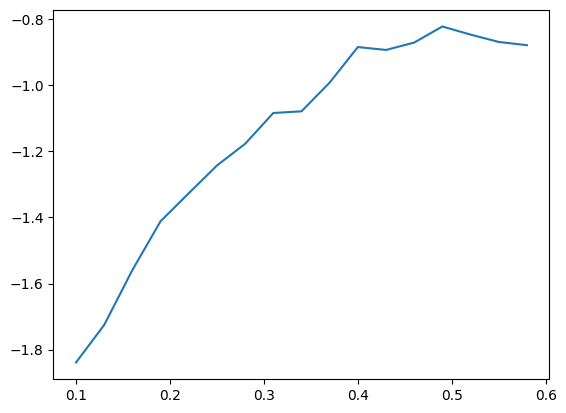

In [53]:
plt.plot(alpha_arr, energies_arr)

In [88]:
variances_arr

[np.float64(1.7887068485838067),
 np.float64(1.2774813410436163),
 np.float64(1.78741885280265),
 np.float64(1.418414557018304),
 np.float64(1.303232662434587),
 np.float64(1.3175557546473673),
 np.float64(1.4036888910018246),
 np.float64(1.375750330703632),
 np.float64(1.190929742943898),
 np.float64(2.61871735296424),
 np.float64(1.8097413690564612),
 np.float64(1.5427995719170275),
 np.float64(1.981562277531164),
 np.float64(1.1949115719229308),
 np.float64(1.4131013985620933),
 np.float64(1.8460131771859163),
 np.float64(0.9871064158072744),
 np.float64(1.8080588846552716),
 np.float64(1.7837858367719992),
 np.float64(1.2429498403618995),
 np.float64(1.4983102637173629),
 np.float64(1.2846554104793566),
 np.float64(2.07000190036569),
 np.float64(1.060419305889698),
 np.float64(1.2644415048119058),
 np.float64(1.736492016088294),
 np.float64(2.7268945756421235),
 np.float64(1.254744679928106),
 np.float64(1.0817494141115653),
 np.float64(1.5297643402544967),
 np.float64(1.2719031087

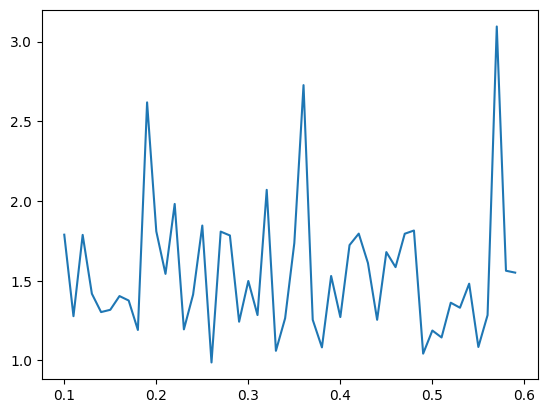

In [87]:
plt.plot(alpha_arr, variances_arr)

In [73]:
variances_arr

[np.float64(-1.1017817472962497),
 np.float64(-3.7603918117437694),
 np.float64(-1.799449147373918),
 np.float64(-1.6364581668574258),
 np.float64(-1.3299913190175836),
 np.float64(-1.8188621805083054),
 np.float64(-0.88700139675752),
 np.float64(-3.9065942954960065),
 np.float64(-22.798927203035568),
 np.float64(-1.2042415525140986),
 np.float64(-1.0581808374636632),
 np.float64(-2.039185023386334),
 np.float64(-2.3093198932641545),
 np.float64(-5.453381226104222),
 np.float64(-1.697735018668197),
 np.float64(-1.4292296328941203),
 np.float64(-4.765163759740384),
 np.float64(-1.0479414545909498),
 np.float64(-1.1943164979087004),
 np.float64(-1.278486139853719),
 np.float64(-1.4915371575783885),
 np.float64(-2.8515814872717375),
 np.float64(-0.9614259585153497),
 np.float64(-0.8331302665768634),
 np.float64(-0.8211417020107772),
 np.float64(-0.8521428117252845),
 np.float64(-2.0832005745563933),
 np.float64(-0.9369282617457921),
 np.float64(-1.4209924713842512),
 np.float64(-2.1401260